In [1]:
import numpy as np 
import pandas as pd 
from pathlib import Path

from fastai import *
from fastai.vision import *
from fastai.callbacks import ReduceLROnPlateauCallback, EarlyStoppingCallback, SaveModelCallback

import os

In [2]:
os.listdir('../input/dermmel/DermMel/')

['test', 'train_sep', 'valid']

In [3]:
data_path = Path('../input/dermmel/DermMel/')

In [4]:
transforms = get_transforms(do_flip = True, 
                            flip_vert = True, 
                            max_rotate = 355.0, 
                            max_zoom = 1.5, 
                            max_lighting = 0.3, 
                            max_warp = 0.2, 
                            p_affine = 0.75, 
                            p_lighting = 0.75)

In [5]:
data = ImageDataBunch.from_folder(data_path,
                                  valid_pct = 0.15,
                                  size = 200,
                                  bs = 64,
                                  ds_tfms = transforms
                                 )

data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (15135 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
NotMelanoma,NotMelanoma,NotMelanoma,NotMelanoma,NotMelanoma
Path: ../input/dermmel/DermMel;

Valid: LabelList (2670 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
NotMelanoma,Melanoma,NotMelanoma,Melanoma,NotMelanoma
Path: ../input/dermmel/DermMel;

Test: None

In [6]:
data.classes

['Melanoma', 'NotMelanoma']

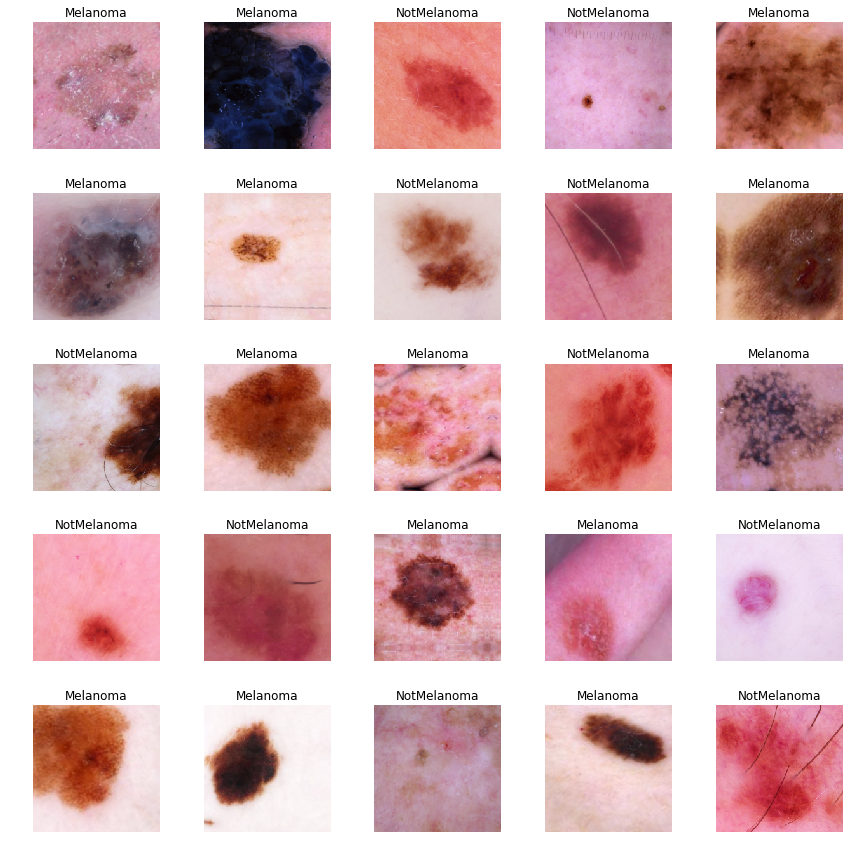

In [7]:
data.show_batch(rows = 5, figsize = (12, 12))

In [8]:
learn = cnn_learner(data, models.resnet152 , metrics = [accuracy], model_dir = '/tmp/model/')

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
241530880it [00:11, 21276959.49it/s]


In [9]:
reduce_lr_pateau = ReduceLROnPlateauCallback(learn, patience = 2, factor = 0.2, monitor = 'accuracy')

early_stopping = EarlyStoppingCallback(learn, monitor = 'accuracy', patience = 6)

save_model = SaveModelCallback(learn, monitor = 'accuracy', every = 'improvement')

callbacks = [reduce_lr_pateau, early_stopping, save_model]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-05


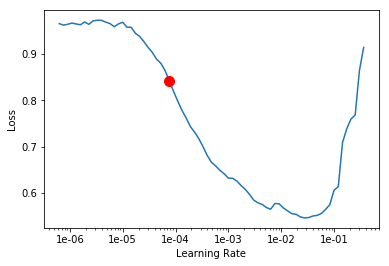

In [10]:
learn.unfreeze()

learn.lr_find()

learn.recorder.plot(suggestion = True)

In [11]:
min_grad_lr = learn.recorder.min_grad_lr

learn.fit_one_cycle(50, min_grad_lr, callbacks = callbacks, wd = 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.341628,0.225500,0.933333,05:20
1,0.245599,0.188249,0.941948,04:58
2,0.206718,0.146749,0.946817,04:58
3,0.192442,0.128845,0.949064,04:58
4,0.161536,0.115533,0.954307,04:59
5,0.156806,0.120914,0.951311,04:59
6,0.147727,0.127988,0.953558,04:57
7,0.141807,0.111407,0.951685,04:57
8,0.140367,0.106793,0.956554,05:02
9,0.147541,0.127695,0.953933,04:57


Better model found at epoch 0 with accuracy value: 0.9333333373069763.
Better model found at epoch 1 with accuracy value: 0.9419475793838501.
Better model found at epoch 2 with accuracy value: 0.9468165040016174.
Better model found at epoch 3 with accuracy value: 0.9490636587142944.
Better model found at epoch 4 with accuracy value: 0.9543071389198303.
Epoch 7: reducing lr to 8.650419082899704e-06
Better model found at epoch 8 with accuracy value: 0.9565542936325073.
Better model found at epoch 11 with accuracy value: 0.9602996110916138.


In [12]:
learn.save('model')

In [13]:
learn.load('model')

Learner(data=ImageDataBunch;

Train: LabelList (15135 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
NotMelanoma,NotMelanoma,NotMelanoma,NotMelanoma,NotMelanoma
Path: ../input/dermmel/DermMel;

Valid: LabelList (2670 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
NotMelanoma,Melanoma,NotMelanoma,Melanoma,NotMelanoma
Path: ../input/dermmel/DermMel;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Ba

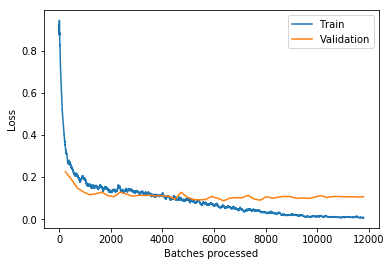

In [14]:
learn.recorder.plot_losses()

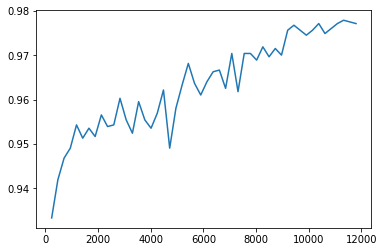

In [15]:
learn.recorder.plot_metrics()

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

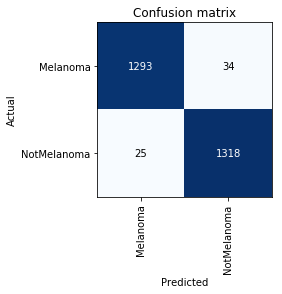

In [17]:
interp.plot_confusion_matrix()

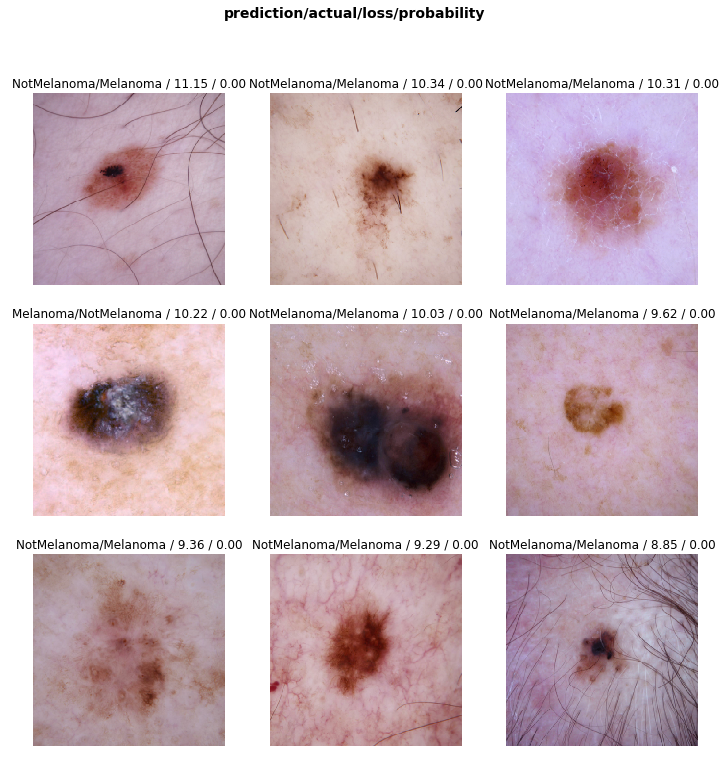

In [18]:
interp.plot_top_losses(9, figsize = (12, 12), heatmap = False)

In [19]:
interp.most_confused()

[('Melanoma', 'NotMelanoma', 34), ('NotMelanoma', 'Melanoma', 25)]

In [20]:
predictions, y, loss = learn.get_preds(with_loss = True)

acc = accuracy(predictions, y)

In [21]:
print('Accuracy: {0}'.format(acc))

Accuracy: 0.9779026508331299
